### Create load road data

In [1]:
# pip install xlrd

In [2]:
# pip install openpyxl

Goed voorbeeld van consecutive outliers: Z1081 <br>
Van single outliers: N1 <br>
Van end-outliers: N6

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN

In [4]:
# import road data
df_rd = pd.read_csv('data/_roads.tsv', sep='\t', low_memory=False) # This file only shows the roadnr, name, length, and start and end place

# df_rd.describe()
display(df_rd)

,road,lrp1,lat1,lon1,lrp2,lat2,lon2,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 4035,Unnamed: 4036,Unnamed: 4037,Unnamed: 4038,Unnamed: 4039,Unnamed: 4040,Unnamed: 4041,Unnamed: 4042,Unnamed: 4043,Unnamed: 4044
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,92.29825,LRP466c,20.864667,92.298194,LRP467,20.862972,92.298083,LRPE,20.862917,92.298083
1,N101,LRPS,23.454139,91.212861,LRPSa,23.461889,91.212000,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N103,LRPS,23.957028,91.115528,LRP001,23.961917,91.113611,LRP001a,23.967666,91.111889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N104,LRPS,23.009667,91.399416,LRPSa,23.009278,91.395250,LRP001,23.009306,91.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,Z8910,LRPS,22.674722,90.408889,LRPSa,22.675916,90.412556,LRP001,22.675583,90.417166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,Z8913,LRPS,22.396083,90.688666,LRPSa,22.393027,90.688944,LRPSb,22.392666,90.689083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,Z8915,LRPS,22.589389,90.619472,LRP001,22.589694,90.623360,LRP001a,22.590027,90.631360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
883,Z8916,LRPS,22.625499,90.661722,LRPSa,22.623888,90.664167,LRP001,22.620305,90.668999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Import the bridge data
df_brd = pd.read_excel('data/BMMS_overview.xlsx')

#### Create plot function

In [6]:
# Create a plot function
def plot_map(df_rd, title):
    plt.figure(figsize=(10, 10))

    # Get unique roads and create a colormap
    # colormap = cm.get_cmap('tab10', num_roads)

    # Group by road and plot efficiently
    try:
        roads = df_rd['road'].unique()
        num_roads = len(roads)
        for idx, (road, group) in enumerate(df_rd.groupby('road')):
            plt.plot(group['LON'], group['LAT'], 'o-', markersize=3)#, color=color)
    except:
        group = df_rd
        plt.plot(group['LON'], group['LAT'], 'o-', markersize=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.show()


In [7]:
def plot_removed_datapoints(df, list_of_removed_points, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(df['LON'], df['LAT'], 'o', label=f'Cluster non-outliers')

    # plot outliers
    if len(list_of_removed_points) > 0:
        removed_points = pd.DataFrame(list_of_removed_points)
        ax.plot(removed_points['LON'], removed_points['LAT'], 'ro', label='Outliers')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()
    plt.show()


## Fixing single outliers - for one road

In [8]:
df_rd[df_rd['road'] == 'N6']

,road,lrp1,lat1,lon1,lrp2,lat2,lon2,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 4035,Unnamed: 4036,Unnamed: 4037,Unnamed: 4038,Unnamed: 4039,Unnamed: 4040,Unnamed: 4041,Unnamed: 4042,Unnamed: 4043,Unnamed: 4044
68,N6,LRPS,23.957806,89.606889,LRPSa,23.958583,89.605611,LRPSb,23.958889,89.604972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_rd.iloc[68]

road                    N6
lrp1                  LRPS
lat1             23.957806
lon1             89.606889
lrp2                 LRPSa
                   ...    
Unnamed: 4040          NaN
Unnamed: 4041          NaN
Unnamed: 4042          NaN
Unnamed: 4043          NaN
Unnamed: 4044          NaN
Name: 68, Length: 4045, dtype: object

In [10]:
specific_road = df_rd.iloc[68]

# Select every third value for 'LAT' and every third +1 value for 'LON'
df_rd_N1 = pd.DataFrame({
    'LRP': specific_road.iloc[1::3].values,   # Every third value
    'LAT': specific_road.iloc[2::3].values,   # Every third value
    'LON': specific_road.iloc[3::3].values   # Every third +1 value
})

df_rd_N1['LAT'] = df_rd_N1['LAT'].astype(float)
df_rd_N1['LON'] = df_rd_N1['LON'].astype(float)

df_rd_N1

,LRP,LAT,LON
0,LRPS,23.957806,89.606889
1,LRPSa,23.958583,89.605611
2,LRPSb,23.958889,89.604972
3,LRP001,23.960417,89.598166
4,LRP002,23.961139,89.588389
...,...,...,...
1343,NaN,NaN,NaN
1344,NaN,NaN,NaN
1345,NaN,NaN,NaN
1346,NaN,NaN,NaN


In [11]:
# Calculate the distance between two points

def calc_lrp_distance(df_rd_lrp):
    df_lrp_before = df_rd_lrp.shift()  # The LRP before
    lrp_dist = np.sqrt((df_lrp_before["LAT"] - df_rd_lrp["LAT"])**2 + (df_lrp_before["LON"] - df_rd_lrp["LON"])**2)
    df_rd_lrp["LRP_dist"] = lrp_dist

    return df_rd_lrp

df_rd_N1 = calc_lrp_distance(df_rd_N1)
display(df_rd_N1)

,LRP,LAT,LON,LRP_dist
0,LRPS,23.957806,89.606889,NaN
1,LRPSa,23.958583,89.605611,0.001496
2,LRPSb,23.958889,89.604972,0.000708
3,LRP001,23.960417,89.598166,0.006975
4,LRP002,23.961139,89.588389,0.009804
...,...,...,...,...
1343,NaN,NaN,NaN,NaN
1344,NaN,NaN,NaN,NaN
1345,NaN,NaN,NaN,NaN
1346,NaN,NaN,NaN,NaN


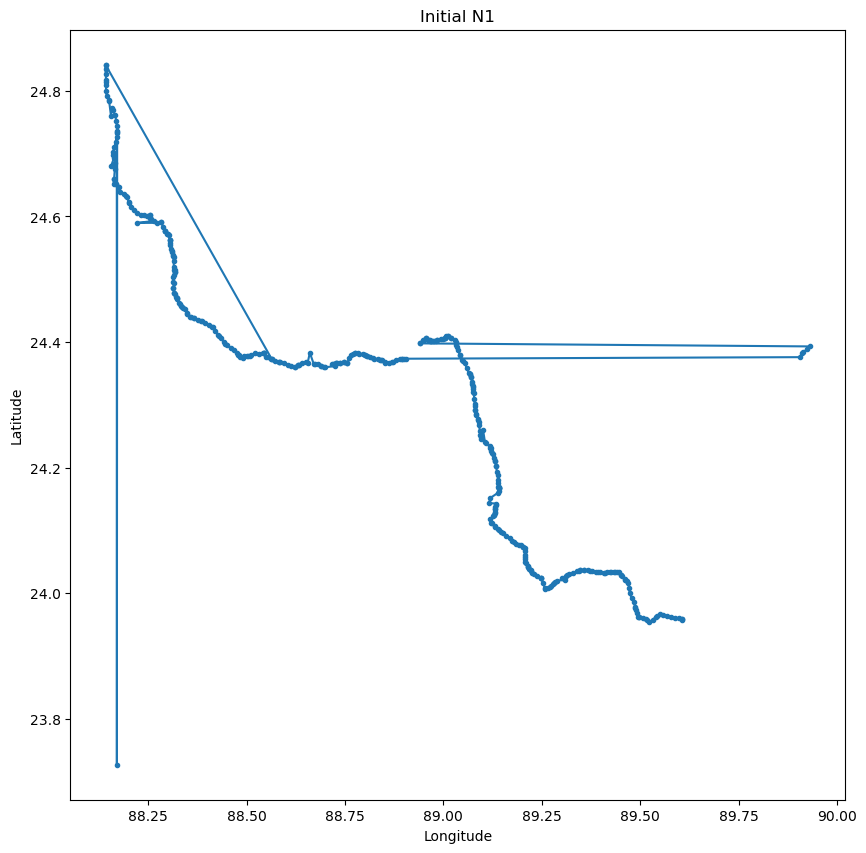

In [12]:
plot_map(df_rd_N1, 'Initial N1')

<Axes: >

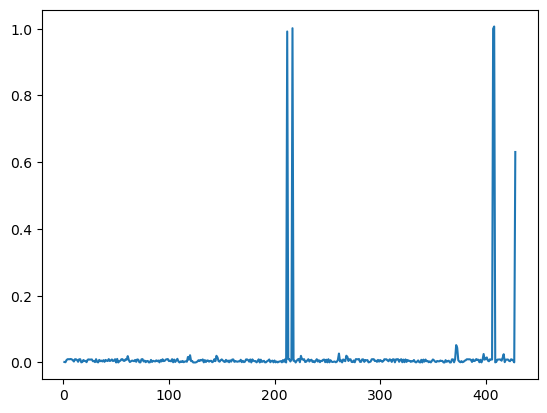

In [13]:
df_rd_N1.LRP_dist.plot()

In [14]:
df_rd_N1.LRP_dist.describe()

count    428.000000
mean       0.016513
std        0.100406
min        0.000000
25%        0.002336
50%        0.005083
75%        0.008880
max        1.006612
Name: LRP_dist, dtype: float64

### Which LRPs are off the road
For the single (individual) LRPs off the road: one is off the road then the next one is on the road agaiin! But both edges are longer than 'usual'.

For more than one successive LRPs off the road, see `get_lrps_off_rd_2`

In [15]:
def get_lrps_off_rd(lrp_dist):
    threshold = lrp_dist.LRP_dist.quantile(0.8) * 20  # 80% of the LRP distances are below this value

    # both edges before and after the LRP are long
    lrp_off_rd = lrp_dist.LRP_dist.loc[(lrp_dist.LRP_dist > threshold) & (lrp_dist.LRP_dist.shift(-1) > threshold)]
    return lrp_off_rd

lrp_off_rd = get_lrps_off_rd(df_rd_N1)

print('count:' + str(lrp_off_rd.count()))
print(lrp_off_rd)
print(df_rd_N1.loc[lrp_off_rd.index])

count:1
407    0.999806
Name: LRP_dist, dtype: float64
         LRP        LAT        LON  LRP_dist
407  LRP217a  23.726944  88.170444  0.999806


#### Pull back the single LRPs that were found

[407]


C:\Users\groen\AppData\Local\Temp\ipykernel_3100\1366590215.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_rd.LAT.loc[lrp_off_rd.index] = 0.5 * (df_rd.LAT.shift().loc[lrp_off_rd.index] + df_rd.LAT.shift(-1).loc[lrp_off_rd.index])
C:\

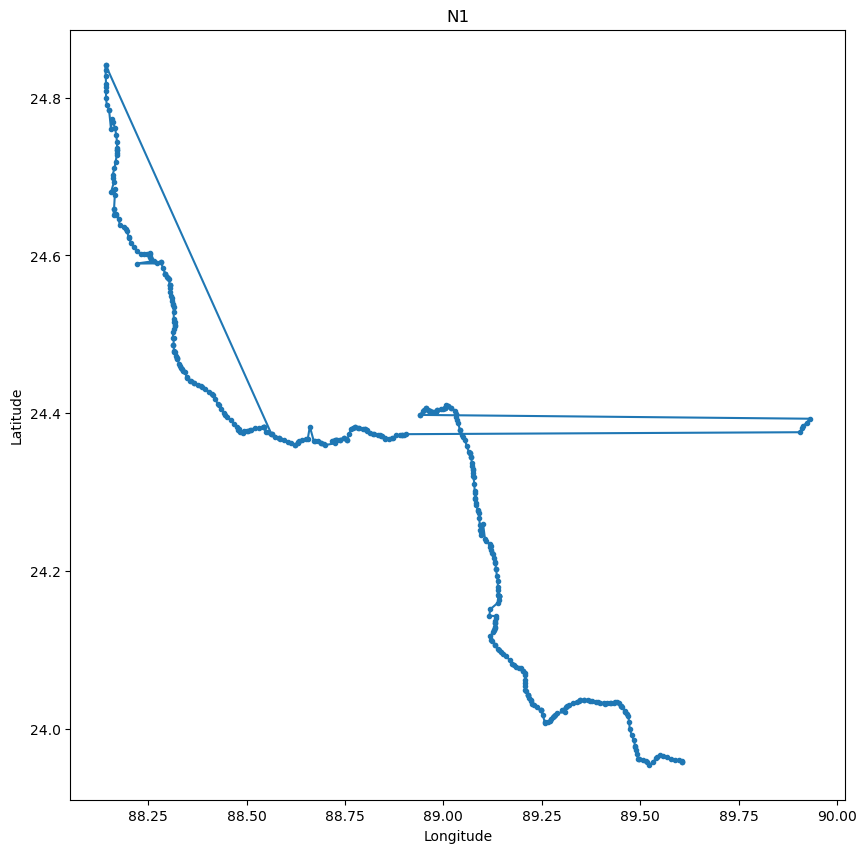

In [16]:
def correct_lrps_off_rd(df_rd, lrp_off_rd):
    df_rd.LAT.loc[lrp_off_rd.index] = 0.5 * (df_rd.LAT.shift().loc[lrp_off_rd.index] + df_rd.LAT.shift(-1).loc[lrp_off_rd.index])
    df_rd.LON.loc[lrp_off_rd.index] = 0.5 * (df_rd.LON.shift().loc[lrp_off_rd.index] + df_rd.LON.shift(-1).loc[lrp_off_rd.index])

    return df_rd # vanaf hier niet meegeschreven voor deze functie

df_rd_N1_new = correct_lrps_off_rd(df_rd_N1.copy(), lrp_off_rd.copy())
lrp_changed_index = lrp_off_rd.index.tolist()
print(lrp_changed_index)

# Recalculate the LRP_distances
df_rd_N1_new = calc_lrp_distance(df_rd_N1_new)

# Plot the road data for the N1
plot_map(df_rd_N1_new, 'N1')

<Axes: >

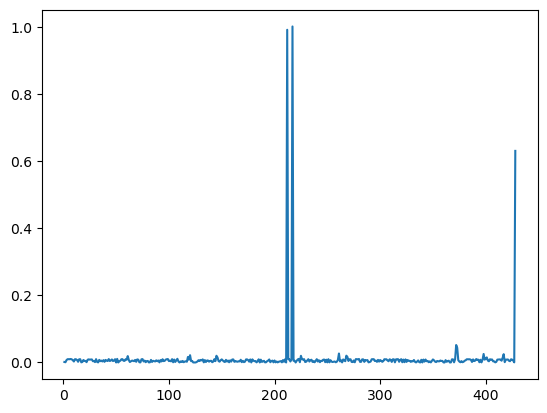

In [17]:
df_rd_N1_new.LRP_dist.plot()

### Now for all rows - fixing single outliers

,road,LRP,LAT,LON
0,N1,LRPS,23.706028,90.443333
1,N1,LRPSa,23.702917,90.450417
2,N1,LRPSb,23.702778,90.450472
3,N1,LRP001,23.702139,90.451972
4,N1,LRP002,23.697889,90.460583
...,...,...,...,...
1192975,Z8943,NaN,NaN,NaN
1192976,Z8943,NaN,NaN,NaN
1192977,Z8943,NaN,NaN,NaN
1192978,Z8943,NaN,NaN,NaN


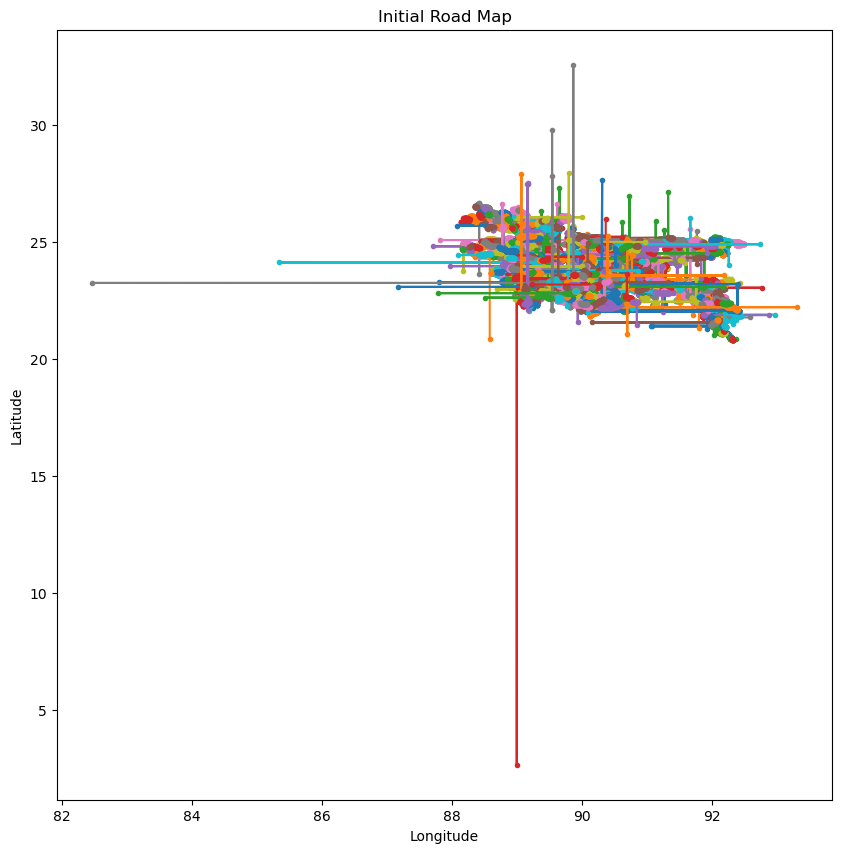

C:\Users\groen\AppData\Local\Temp\ipykernel_3100\2165844085.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rd_lrp["LRP_Dist"] = df_rd_lrp.groupby("road").apply(


,road,LRP,LAT,LON,LRP_Dist
0,N1,LRPS,23.706028,90.443333,NaN
1,N1,LRPSa,23.702917,90.450417,0.007737
2,N1,LRPSb,23.702778,90.450472,0.000150
3,N1,LRP001,23.702139,90.451972,0.001630
4,N1,LRP002,23.697889,90.460583,0.009603
...,...,...,...,...,...
1192975,Z8943,NaN,NaN,NaN,NaN
1192976,Z8943,NaN,NaN,NaN,NaN
1192977,Z8943,NaN,NaN,NaN,NaN
1192978,Z8943,NaN,NaN,NaN,NaN


Off-road LRPs:


,road,LRP,LAT,LON,LRP_Dist
69,N1,LRP027a,22.583750,90.636944,1.005876
154,N1,LRP065,22.499527,90.954167,1.002543
233,N1,LRP108,22.339055,91.267222,1.007321
538,N1,LRP225,22.451861,91.466611,0.263948
553,N1,LRP230c,22.758417,91.755139,0.350000
...,...,...,...,...,...
1153918,Z8607,LRP008d,22.285000,90.340666,1.000000
1171416,Z8717,LRP001a,22.007194,90.090389,0.566999
1180906,Z8814,LRP022d,22.453333,89.957333,0.166500
1190289,Z8916,LRP003,23.615167,90.685805,1.000792


Corrected LRPs:


C:\Users\groen\AppData\Local\Temp\ipykernel_3100\2165844085.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rd_lrp["LRP_Dist"] = df_rd_lrp.groupby("road").apply(


,road,LRP,LAT,LON,LRP_Dist
0,N1,LRPS,23.706028,90.443333,NaN
1,N1,LRPSa,23.702917,90.450417,0.007737
2,N1,LRPSb,23.702778,90.450472,0.000150
3,N1,LRP001,23.702139,90.451972,0.001630
4,N1,LRP002,23.697889,90.460583,0.009603
...,...,...,...,...,...
1192975,Z8943,NaN,NaN,NaN,NaN
1192976,Z8943,NaN,NaN,NaN,NaN
1192977,Z8943,NaN,NaN,NaN,NaN
1192978,Z8943,NaN,NaN,NaN,NaN


In [18]:
# Function to extract LRP, LAT, and LON for each road
def extract_lrps(df_rd):
    all_roads = []
    
    for i in range(len(df_rd)):  # Loop through all rows (roads)
        row = df_rd.iloc[i]

        # print(row.iloc[0])

        # Extract every third value for LRP, LAT, and LON
        df_rd_long = pd.DataFrame({
            'road': row.iloc[0],
            'LRP': row.iloc[1::3].values,
            'LAT': row.iloc[2::3].astype(float).values,
            'LON': row.iloc[3::3].astype(float).values
        })
        
        # df_rd_N1['Road_ID'] = i  # Add road number 
        all_roads.append(df_rd_long)  # Append results

    return pd.concat(all_roads, ignore_index=True)  # Merge all road data

df_rd_long = extract_lrps(df_rd)
display(df_rd_long)
plot_map(df_rd_long, 'Initial Road Map')

# Function to calculate LRP distances for all roads
def calc_lrp_distance(df_rd_lrp):
    df_rd_lrp["LRP_Dist"] = df_rd_lrp.groupby("road").apply(
        lambda group: np.sqrt(
            (group["LAT"].shift() - group["LAT"])**2 + 
            (group["LON"].shift() - group["LON"])**2
        )
    ).reset_index(level=0, drop=True)
    
    return df_rd_lrp

df_rd_long = calc_lrp_distance(df_rd_long)
display(df_rd_long)

# Identify LRPs that are off-road
def get_lrps_off_rd(lrp_dist):
    threshold = lrp_dist.groupby("road")["LRP_Dist"].transform(lambda x: x.quantile(0.8) * 20)
    lrp_off_rd = lrp_dist.loc[(lrp_dist["LRP_Dist"] > threshold) & (lrp_dist["LRP_Dist"].shift(-1) > threshold)]
    return lrp_off_rd

lrp_off_rd = get_lrps_off_rd(df_rd_long)
print("Off-road LRPs:")
display(lrp_off_rd)

# Correct LRPs that are off-road
def correct_lrps_off_rd(df_rd, lrp_off_rd):
    for index in lrp_off_rd.index:
        df_rd.at[index, "LAT"] = 0.5 * (df_rd.at[index - 1, "LAT"] + df_rd.at[index + 1, "LAT"])
        df_rd.at[index, "LON"] = 0.5 * (df_rd.at[index - 1, "LON"] + df_rd.at[index + 1, "LON"])
    
    return df_rd

df_rd_new = correct_lrps_off_rd(df_rd_long.copy(), lrp_off_rd)
print("Corrected LRPs:")
# Recalculate the LRP_distances
df_rd_new = calc_lrp_distance(df_rd_new)

display(df_rd_new)


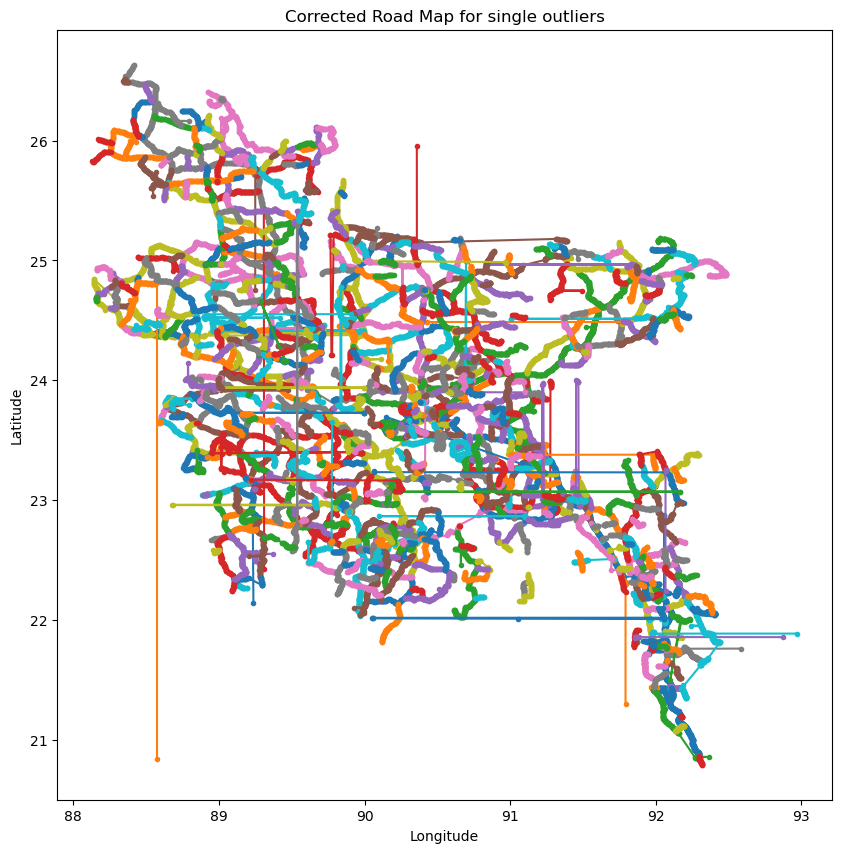

In [19]:
plot_map(df_rd_new, 'Corrected Road Map for single outliers')


## Transform back to good format
Just as a test - best way to do this is probably at the end, as we also want to fix the data based on other rules

In [20]:
def transform_to_original_format(df_rd_new):
    """
    Transforms df_rd_new into the original wide format where each road is a row,
    and each LRP, LAT, and LON is stored in separate columns.
    
    Parameters:
    df_rd_new (pd.DataFrame): DataFrame with columns ['road', 'LRP', 'LAT', 'LON'].

    Returns:
    pd.DataFrame: Transformed DataFrame in the original format.
    """
    # Pivot the dataframe to the wide format
    df_rd_pivot = df_rd_new.groupby("road").apply(
        lambda x: x[['LRP', 'LAT', 'LON']].values.flatten()
    ).apply(pd.Series)

    # Rename columns dynamically
    df_rd_pivot.columns = [f"{col}{i//3+1}" for i, col in enumerate(['lrp', 'lat', 'lon'] * (df_rd_pivot.shape[1] // 3))]

    # Reset index to bring 'road' back as a column
    df_rd_pivot.reset_index(inplace=True)

    return df_rd_pivot

df_rd_transformed = transform_to_original_format(df_rd_new)
display(df_rd_transformed)


C:\Users\groen\AppData\Local\Temp\ipykernel_3100\1243049080.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rd_pivot = df_rd_new.groupby("road").apply(


,road,lrp1,lat1,lon1,lrp2,lat2,lon2,lrp3,lat3,lon3,...,lon1345,lrp1346,lat1346,lon1346,lrp1347,lat1347,lon1347,lrp1348,lat1348,lon1348
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,92.29825,LRP466c,20.864667,92.298194,LRP467,20.862972,92.298083,LRPE,20.862917,92.298083
1,N101,LRPS,23.454139,91.212861,LRPSa,23.461889,91.212000,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N103,LRPS,23.957028,91.115528,LRP001,23.961917,91.113611,LRP001a,23.967666,91.111889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N104,LRPS,23.009667,91.399416,LRPSa,23.009278,91.395250,LRP001,23.009306,91.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,Z8910,LRPS,22.674722,90.408889,LRPSa,22.675916,90.412556,LRP001,22.675583,90.417166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,Z8913,LRPS,22.396083,90.688666,LRPSa,22.393027,90.688944,LRPSb,22.392666,90.689083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,Z8915,LRPS,22.589389,90.619472,LRP001,22.589694,90.623360,LRP001a,22.590027,90.631360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
883,Z8916,LRPS,22.625499,90.661722,LRPSa,22.623888,90.664167,LRP001,22.620305,90.668999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## For multiple outliers after eachother
Steps: <br>

1. Test for one road (N1)
    1. Find the outliers 
    2. Interpolate between the outliers
2. Rebuild the code for all roads
    1. Find the outliers
    2. Interpolate between the outliers

<Axes: >

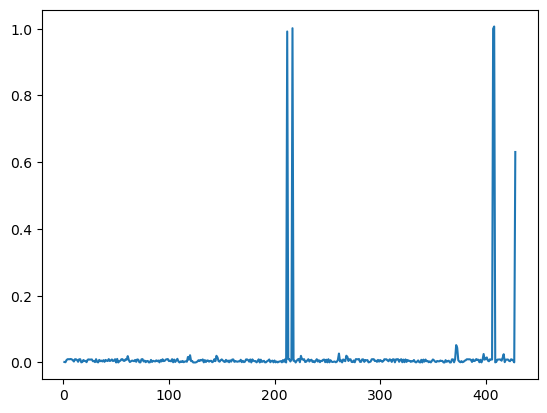

In [21]:
# Show the distribuation of the LRP distance for the N1
df_rd_N1.LRP_dist.plot()

In [22]:
def find_consecutive_outliers(df, quantile_value=0.80, multiplier=20, similarity_threshold=0.10, max_group_size=10):
    # Compute the threshold for identifying potential outliers
    threshold = df['LRP_dist'].quantile(quantile_value) * multiplier

    # Identify rows where LRP_dist exceeds the threshold
    outlier_indices = df.index[df['LRP_dist'] > threshold].tolist()
    print(outlier_indices)

    # List to store groups of consecutive outliers
    outlier_groups = []
    visited = set()

    for idx in outlier_indices:
        if idx in visited:
            continue

        group = [idx]

        # Check the next 10 rows for similar LRP_dist values
        for offset in range(1, max_group_size + 1):  
            next_idx = idx + offset
            if next_idx in df.index and next_idx not in visited:
                ref_dist = df.at[idx, 'LRP_dist']
                next_dist = df.at[next_idx, 'LRP_dist']

                # Check if the next LRP_dist is within similarity threshold
                if ref_dist <= next_dist * (1 + similarity_threshold) and ref_dist >= next_dist * (1 - similarity_threshold):
                    group.append(next_idx)
                    break
                else:
                    continue
        
        print(f'group {group}')

        # Only store groups with 2 to max_group_size members
        if 1 < len(group) <= max_group_size:
            outlier_groups.append(group)
            visited.update(group)  # Mark indices as visited

    # Create an output DataFrame containing the detected consecutive outliers
    outlier_df = df.loc[np.concatenate(outlier_groups)].copy()
    outlier_df['outlier_group'] = np.repeat(range(1, len(outlier_groups) + 1), [len(g) for g in outlier_groups])

    return outlier_df

consecutive_outliers = find_consecutive_outliers(df_rd_N1)

print(consecutive_outliers)


[212, 217, 407, 408, 428]
group [212, 217]
group [407, 408]
group [428]
         LRP        LAT        LON  LRP_dist  outlier_group
212   LRP109  24.393083  89.931555  0.991567              1
217  LRP112a  24.373499  88.904556  1.001392              1
407  LRP217a  23.726944  88.170444  0.999806              2
408  LRP217b  24.733555  88.171249  1.006612              2


In [23]:
# # Interpolate the LRP values for the consecutive outliers, using the Euclidean distance  

# def interpolate_consecutive_outliers(df, outlier_df):
#     for group_id, group in outlier_df.groupby('outlier_group'):
#         start_idx = group.index[0]
#         end_idx = group.index[-1]

#         # Calculate the Euclidean distance between the start and end points
#         start_point = df.loc[start_idx, ['LAT', 'LON']].values
#         end_point = df.loc[end_idx, ['LAT', 'LON']].values
#         start_end_dist = np.linalg.norm(start_point - end_point)

#         print(start_point, end_point, start_end_dist)

#         # Interpolate the LAT and LON values for the outliers
#         for idx, row in group.iterrows(): 
#             dist = np.linalg.norm(start_point - df.loc[idx, ['LAT', 'LON']].values)
#             ratio = dist / start_end_dist
#             df.at[idx, 'LAT'] = start_point[0] + ratio * (end_point[0] - start_point[0])
#             df.at[idx, 'LON'] = start_point[1] + ratio * (end_point[1] - start_point[1])

#     return df

# df_rd_N1_interpolated = interpolate_consecutive_outliers(df_rd_N1.copy(), consecutive_outliers)

In [24]:
def interpolate_consecutive_outliers(df, outlier_df):
    for group_id, group in outlier_df.groupby('outlier_group'):
        start_idx = group.index[0] - 1  # Last valid point before outliers
        end_idx = group.index[-1]   # First valid point after outliers

        # Ensure start and end indices are valid
        if start_idx < 0 or end_idx >= len(df):
            continue 

        start_point = df.loc[start_idx, ['LAT', 'LON']].values
        end_point = df.loc[end_idx, ['LAT', 'LON']].values

        print(start_point, end_point)

        # Interpolate
        num_points = end_idx - start_idx + 1
        lat_interp = np.linspace(start_point[0], end_point[0], num_points)[1:-1]
        lon_interp = np.linspace(start_point[1], end_point[1], num_points)[1:-1]

        # Assign interpolated values to outlier rows
        for i in range(start_idx + 1, end_idx):
            print(df.loc[i, 'LAT'], df.loc[i, 'LON'])
            df.loc[i, 'LON'] = lon_interp[i - start_idx - 1]
            df.loc[i, 'LAT'] = lat_interp[i - start_idx - 1]
    return df

# Apply interpolation
df_rd_N1_interpolated = interpolate_consecutive_outliers(df_rd_N1.copy(), consecutive_outliers)


[np.float64(24.3979163) np.float64(88.9399997)] [np.float64(24.3734993) np.float64(88.9045556)]
24.393083 89.93155490000001
24.3882497 89.9231104
24.3838052 89.9145556
24.3818882 89.9123056
24.3759716 89.9059444
[np.float64(24.7267493) np.float64(88.17022159999999)] [np.float64(24.7335552) np.float64(88.1712493)]
23.7269438 88.1704438


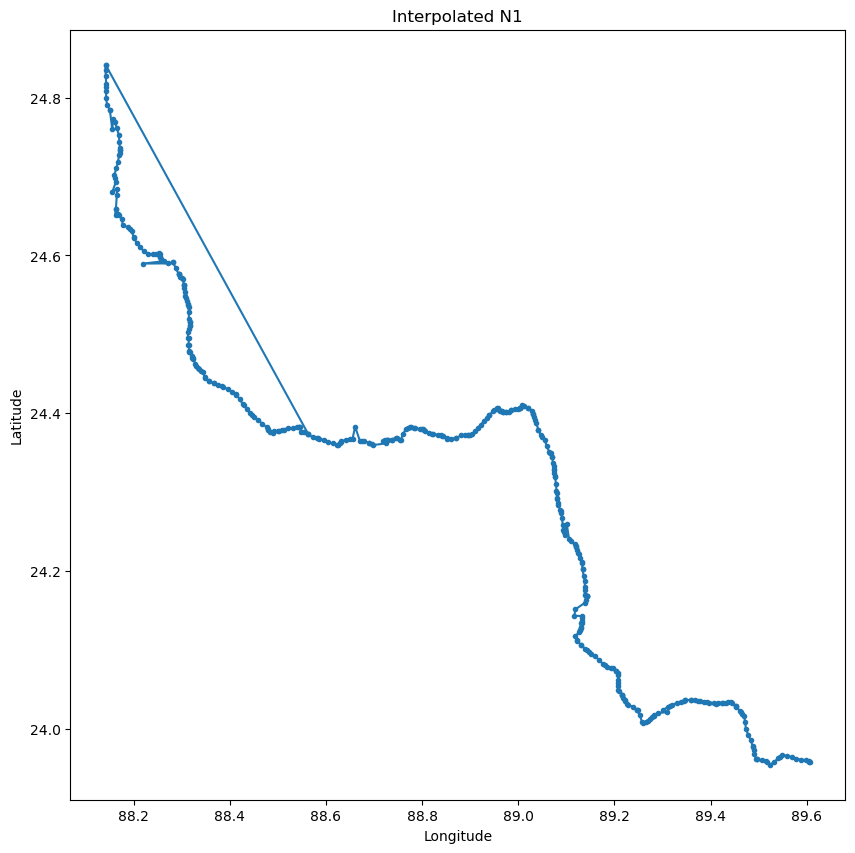

In [25]:
plot_map(df_rd_N1_interpolated, 'Interpolated N1')


### Fix the consecutive outliers for all roads

In [26]:
# Now for all roads

def find_consecutive_outliers(df, quantile_value=0.80, multiplier=20, similarity_threshold=0.10, max_group_size=10):
    all_outliers = []

    for road, road_df in df.groupby('road'):  # Process each road separately
        threshold = road_df['LRP_Dist'].quantile(quantile_value) * multiplier
        outlier_indices = road_df.index[road_df['LRP_Dist'] > threshold].tolist()
        outlier_groups = []
        visited = set()

        for idx in outlier_indices:
            if idx in visited:
                continue

            group = [idx]

            # Check the next 10 rows for similar LRP_Dist values
            for offset in range(1, max_group_size + 1):
                next_idx = idx + offset
                if next_idx in road_df.index and next_idx not in visited:
                    ref_dist = road_df.at[idx, 'LRP_Dist']
                    next_dist = road_df.at[next_idx, 'LRP_Dist']

                    # Check if the next LRP_Dist is within similarity threshold
                    if ref_dist * (1 - similarity_threshold) <= next_dist <= ref_dist * (1 + similarity_threshold):
                        group.append(next_idx)
                        break
                    else:
                        continue

            # Only store groups with 2 to max_group_size members
            if 1 < len(group) <= max_group_size:
                outlier_groups.append(group)
                visited.update(group)

        # Create DataFrame of outliers for this road
        if outlier_groups:
            road_outlier_df = road_df.loc[np.concatenate(outlier_groups)].copy()
            road_outlier_df['outlier_group'] = np.repeat(range(1, len(outlier_groups) + 1), [len(g) for g in outlier_groups])
            all_outliers.append(road_outlier_df)
        

    # Combine all road outliers into a single DataFrame
    return pd.concat(all_outliers) if all_outliers else pd.DataFrame(columns=df.columns)

def interpolate_consecutive_outliers(df, outlier_df):
    total_changed_points = 0
    for (road, group_id), group in outlier_df.groupby(['road', 'outlier_group']):
        road_df = df[df['road'] == road]  # Get the corresponding road data

        start_idx = group.index[0] - 1  # Last valid point before outliers
        end_idx = group.index[-1] + 1   # First valid point after outliers

        # Ensure valid start and end indices
        # if start_idx < 0 or end_idx >= len(road_df):
        #     continue 

        start_point = df.loc[start_idx, ['LAT', 'LON']].values
        end_point = df.loc[end_idx, ['LAT', 'LON']].values

        # Interpolate
        num_points = end_idx - start_idx + 1
        total_changed_points += num_points
        lat_interp = np.linspace(start_point[0], end_point[0], num_points)[1:-1]
        lon_interp = np.linspace(start_point[1], end_point[1], num_points)[1:-1]

        # Assign interpolated values
        for i, idx in enumerate(range(start_idx + 1, end_idx)):
            df.at[idx, 'LAT'] = lat_interp[i]
            df.at[idx, 'LON'] = lon_interp[i]

    print(f'Total changed consecutive: {total_changed_points}')

    return df

# Apply the process to all roads
consecutive_outliers = find_consecutive_outliers(df_rd_new)
print(consecutive_outliers)
df_rd_new_interpolated = interpolate_consecutive_outliers(df_rd_new.copy(), consecutive_outliers)



          road      LRP        LAT        LON  LRP_Dist  outlier_group
792         N1  LRP323a  22.874916  92.059111  0.995500              1
794         N1  LRP324a  21.862500  92.059500  1.007999              1
72794     N507   LRP002  25.416472  89.542055  0.997648              1
72797     N507  LRP002c  24.413611  89.532527  1.001061              1
91876       N6   LRP109  24.393083  89.931555  0.991567              1
91881       N6  LRP112a  24.373499  88.904556  1.001392              1
139027    R140   LRP079  23.309917  90.728999  0.164918              1
139028    R140  LRP079a  23.142333  90.729305  0.167584              1
187424    R281   LRP018  24.512417  91.005806  0.993777              1
187426    R281   LRP019  24.513111  92.015694  1.009417              1
210370    R371   LRP036  24.622749  90.259861  0.332505              1
210372    R371  LRP036a  24.956750  90.258750  0.334003              1
262894    R745  LRP013b  23.916600  89.223024  0.251442              1
262895

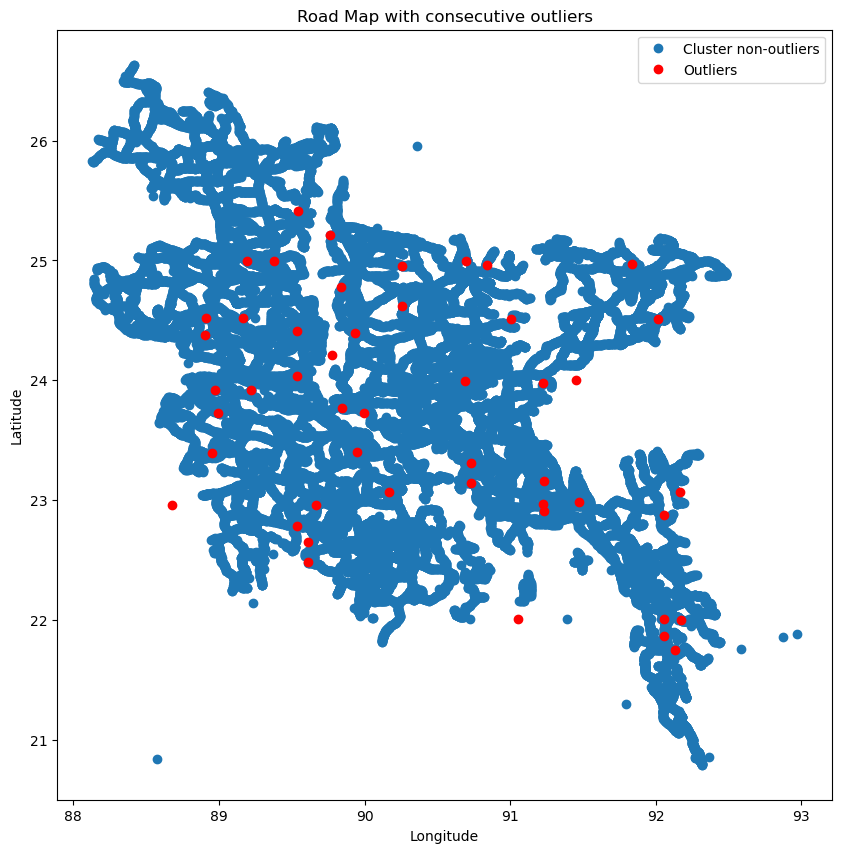

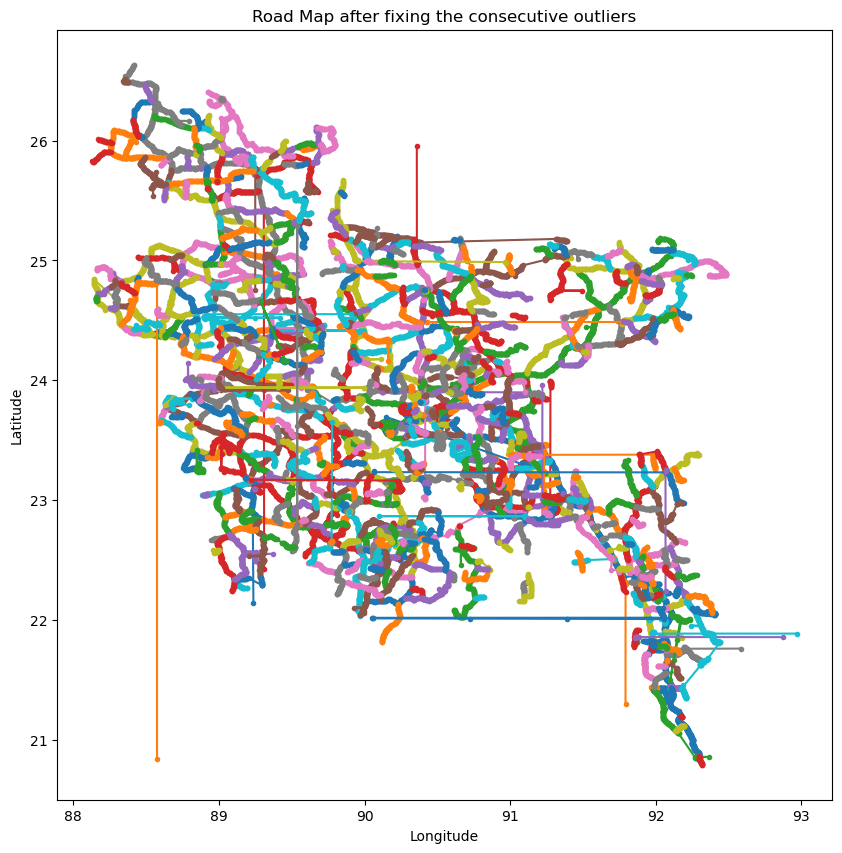

In [27]:
plot_removed_datapoints(df_rd_new_interpolated, consecutive_outliers, 'Road Map with consecutive outliers')
plot_map(df_rd_new_interpolated, 'Road Map after fixing the consecutive outliers')

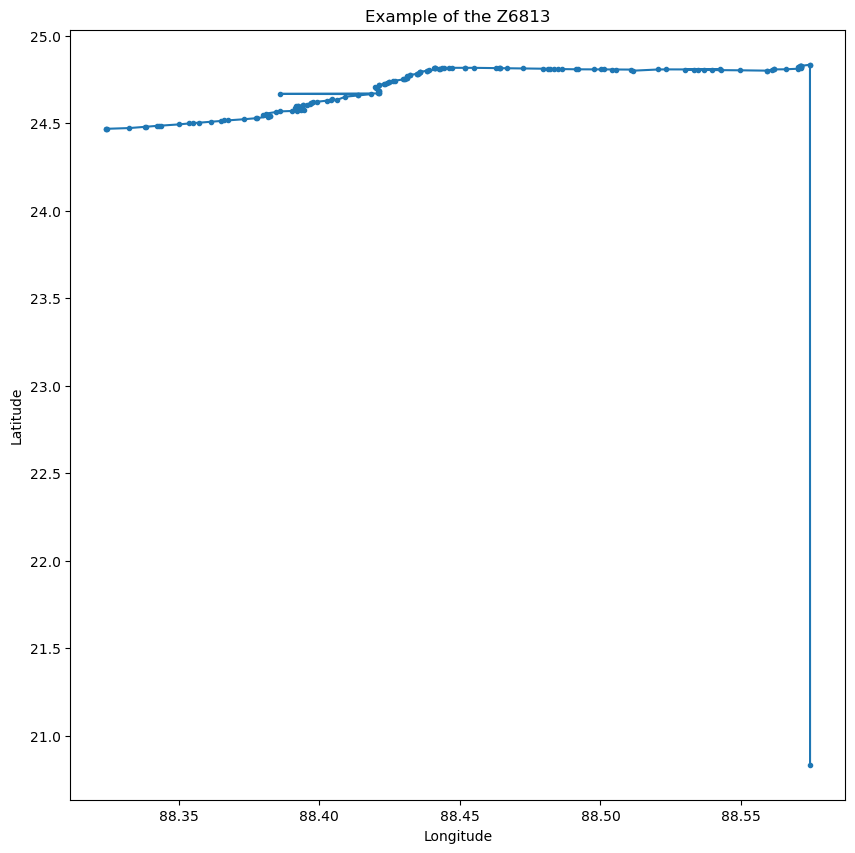

In [28]:
# Example of the Z1421, which as an end-outlier
road_nr = 'Z6813'
plot_map(df_rd_new_interpolated[df_rd_new_interpolated['road'] == road_nr], title=f'Example of the {road_nr}')


## End outliers
The above plot still shows quit some 'weird' datapoints. <br>
--> Some are, as can be observed, end-outliers

Not enough points to cluster
10


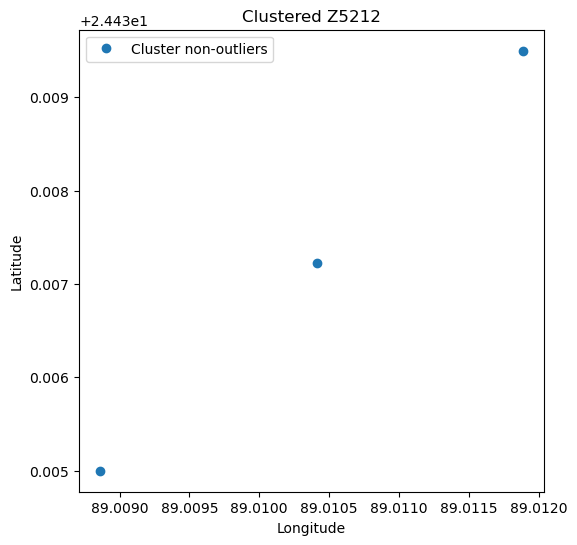

In [29]:
#Test for one road:
road_nr = 'Z5212'
road_without_nans = df_rd_new_interpolated[df_rd_new_interpolated['road'] == road_nr]

def cluster_outliers(df, min_samples=10, cluster_selection_epsilon=0.05):
    # Remove rows with missing LAT and LON values
    df_for_clustering = df.dropna(subset=['LAT', 'LON']).copy()

    # Cluster the points using DBSCAN
    if len(df_for_clustering) < 10:
        print('Not enough points to cluster')
    min_samples_calc = np.max([min_samples, len(df_for_clustering) -5])
    print(min_samples_calc)
    clusterer = DBSCAN(min_samples=min_samples_calc, eps=cluster_selection_epsilon)
    df_for_clustering['cluster'] = clusterer.fit_predict(df_for_clustering[['LAT', 'LON']])

    list_of_removed_points = []

    # Check if there are first or last points that are outliers
    if df_for_clustering['cluster'].iloc[0] == -1 and df_for_clustering['cluster'].iloc[1] != -1:
        print('First point is outlier')
        
        # Remove the first point
        list_of_removed_points.append(df_for_clustering.iloc[0])
        df.drop(df_for_clustering.index[0], inplace=True)

    if df_for_clustering['cluster'].iloc[-1] == -1 and df_for_clustering['cluster'].iloc[-2] != -1:
        print('Last point is outlier')

        # Remove the last point
        list_of_removed_points.append(df_for_clustering.iloc[-1][['LON', 'LAT']])
        df.drop(df_for_clustering.index[-1], inplace=True)

    return df, list_of_removed_points

df_rd_N1_clustered, list_of_removed_points = cluster_outliers(road_without_nans)
# print(list_of_removed_points)

def plot_clustered_map(df, list_of_removed_points, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(df['LON'], df['LAT'], 'o', label=f'Cluster non-outliers')

    # plot outliers
    if len(list_of_removed_points) > 0:
        removed_points = pd.DataFrame(list_of_removed_points)
        ax.plot(removed_points['LON'], removed_points['LAT'], 'ro', label='Outliers')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_clustered_map(df_rd_N1_clustered, list_of_removed_points, f'Clustered {road_nr}')

### End-outliers for all roads

In [30]:
# Now for all roads

def cluster_outliers(df, min_samples=5, cluster_selection_epsilon=0.5):
    list_of_removed_points = []
    removed_indices = []

    for road, road_df in df.groupby('road'):  # Process each road separately
        print(f'Processing road {road}')
        # Remove rows with missing LAT and LON values
        df_for_clustering = road_df.dropna(subset=['LAT', 'LON']).copy()

        # Cluster the points using DBSCAN
        if len(df_for_clustering) < 8:
            print('Not enough points to cluster')
            continue

        min_samples_calc = np.max([min_samples, len(df_for_clustering) -5]) 
        clusterer = DBSCAN(min_samples=min_samples_calc, eps=cluster_selection_epsilon)
        df_for_clustering['cluster'] = clusterer.fit_predict(df_for_clustering[['LAT', 'LON']])

        # Check if there are first or last points that are outliers
        if df_for_clustering['cluster'].iloc[0] == -1 and df_for_clustering['cluster'].iloc[1] != -1:
            print('First point is outlier')
            list_of_removed_points.append(df_for_clustering.iloc[0])
            removed_indices.append(df_for_clustering.index[0])

        if df_for_clustering['cluster'].iloc[-1] == -1 and df_for_clustering['cluster'].iloc[-2] != -1:
            print('Last point is outlier')
            list_of_removed_points.append(df_for_clustering.iloc[-1][['LON', 'LAT']])
            removed_indices.append(df_for_clustering.index[-1])
    
    # Remove the outliers from the original DataFrame
    df_cleaned = df.drop(index=removed_indices)

    return df_cleaned, list_of_removed_points

df_rd_after_cleaning, list_of_removed_points = cluster_outliers(df_rd_new_interpolated)
print(list_of_removed_points)


Processing road N1
Processing road N101
Processing road N102
Processing road N103
Processing road N104
Processing road N105
Processing road N106
Processing road N107
Processing road N108
Processing road N109
Processing road N110
Processing road N111
Last point is outlier
Processing road N112
Processing road N119
Not enough points to cluster
Processing road N120
Processing road N123
Processing road N124
Not enough points to cluster
Processing road N125
Not enough points to cluster
Processing road N126
Not enough points to cluster
Processing road N127
Not enough points to cluster
Processing road N128
Not enough points to cluster
Processing road N129
Processing road N2
Processing road N203
Not enough points to cluster
Processing road N204
Processing road N205
Processing road N206
Processing road N207
Processing road N208
Processing road N209
Not enough points to cluster
Processing road N210
Processing road N211
Not enough points to cluster
Processing road N212
Not enough points to cluster

In [31]:
print(len(list_of_removed_points))

12


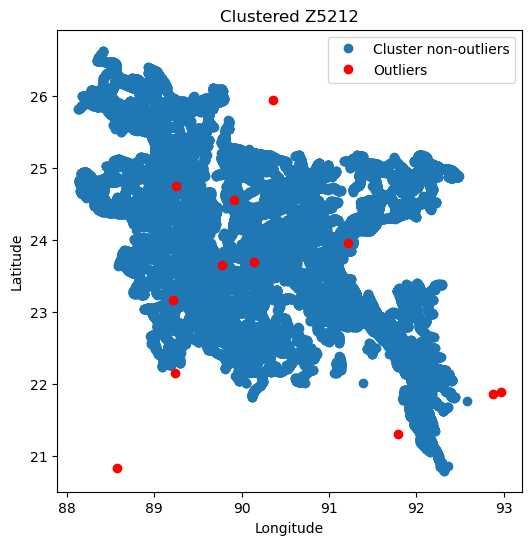

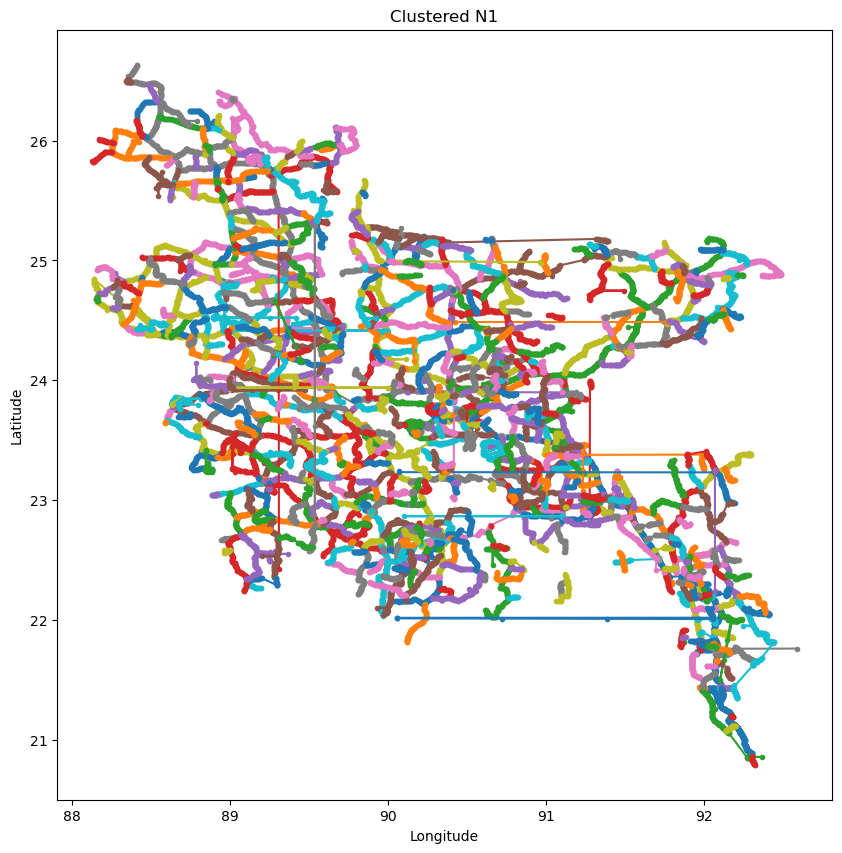

In [32]:
plot_clustered_map(df_rd_after_cleaning, list_of_removed_points, f'Clustered {road_nr}')
plot_map(df_rd_after_cleaning, 'Clustered N1')

### Transform back to normal format to make it possible to use in Java

In [33]:
df_rd_end = transform_to_original_format(df_rd_after_cleaning)
display(df_rd_end)
# df_rd_end.to_csv('data/_roads_cleaned.tsv', sep='\t', index=False)

C:\Users\groen\AppData\Local\Temp\ipykernel_3100\1243049080.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rd_pivot = df_rd_new.groupby("road").apply(


,road,lrp1,lat1,lon1,lrp2,lat2,lon2,lrp3,lat3,lon3,...,lon1345,lrp1346,lat1346,lon1346,lrp1347,lat1347,lon1347,lrp1348,lat1348,lon1348
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,92.29825,LRP466c,20.864667,92.298194,LRP467,20.862972,92.298083,LRPE,20.862917,92.298083
1,N101,LRPS,23.454139,91.212861,LRPSa,23.461889,91.212000,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N103,LRPS,23.957028,91.115528,LRP001,23.961917,91.113611,LRP001a,23.967666,91.111889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N104,LRPS,23.009667,91.399416,LRPSa,23.009278,91.395250,LRP001,23.009306,91.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,Z8910,LRPS,22.674722,90.408889,LRPSa,22.675916,90.412556,LRP001,22.675583,90.417166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,Z8913,LRPS,22.396083,90.688666,LRPSa,22.393027,90.688944,LRPSb,22.392666,90.689083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,Z8915,LRPS,22.589389,90.619472,LRP001,22.589694,90.623360,LRP001a,22.590027,90.631360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
883,Z8916,LRPS,22.625499,90.661722,LRPSa,22.623888,90.664167,LRP001,22.620305,90.668999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
